In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
torch.cuda.empty_cache()
print(f"Using device: {device}")

Using device: cuda


In [3]:
class QuadcopterEnv:
    def __init__(self):
        # Physical parameters
        self.m = 0.5  # mass in kg
        self.g = 9.81  # gravity
        self.l = 0.25  # arm length in meters
        self.Ixx = 5e-3  # moment of inertia
        self.Iyy = 5e-3
        self.Izz = 1e-2
        self.k = 3e-6   # thrust coefficient
        self.b = 1e-7   # drag coefficient
        self.kd = 0.25  # drag coefficient
        
        # Inertia matrix
        self.I = np.array([[self.Ixx, 0, 0],
                          [0, self.Iyy, 0],
                          [0, 0, self.Izz]])
        self.I_inv = np.linalg.inv(self.I)
        
    def rotation_matrix(self, angles):
        """Compute rotation matrix from euler angles (phi, theta, psi)"""
        phi, theta, psi = angles
        
        # Individual rotation matrices
        R_x = np.array([[1, 0, 0],
                       [0, np.cos(phi), -np.sin(phi)],
                       [0, np.sin(phi), np.cos(phi)]])
        
        R_y = np.array([[np.cos(theta), 0, np.sin(theta)],
                       [0, 1, 0],
                       [-np.sin(theta), 0, np.cos(theta)]])
        
        R_z = np.array([[np.cos(psi), -np.sin(psi), 0],
                       [np.sin(psi), np.cos(psi), 0],
                       [0, 0, 1]])
        
        return R_z @ R_y @ R_x
    
    def compute_forces_moments(self, state, inputs):
        """Compute forces and moments from motor inputs"""
        # Motor angular velocities (squared)
        w1, w2, w3, w4 = inputs
        
        # Total thrust
        thrust = self.k * sum(inputs)
        
        # Moments
        tau_phi = self.l * self.k * (w1 - w3)
        tau_theta = self.l * self.k * (w2 - w4)
        tau_psi = self.b * (w1 - w2 + w3 - w4)
        
        return thrust, np.array([tau_phi, tau_theta, tau_psi])
    
    def dynamics(self, state, inputs):
        """Compute state derivatives"""
        # Unpack state
        # [x, y, z, x_dot, y_dot, z_dot, phi, theta, psi, phi_dot, theta_dot, psi_dot]
        pos = state[0:3]
        vel = state[3:6]
        angles = state[6:9]
        omega = state[9:12]
        
        # Compute rotation matrix
        R = self.rotation_matrix(angles)
        
        # Compute forces and moments
        thrust, moments = self.compute_forces_moments(state, inputs)
        
        # Linear accelerations
        gravity = np.array([0, 0, -self.g])
        thrust_body = np.array([0, 0, thrust/self.m])
        acc = gravity + R @ thrust_body - self.kd/self.m * vel
        
        # Angular accelerations
        omega_skew = np.array([[0, -omega[2], omega[1]],
                              [omega[2], 0, -omega[0]],
                              [-omega[1], omega[0], 0]])
        angular_acc = self.I_inv @ (moments - omega_skew @ self.I @ omega)
        
        return np.concatenate([vel, acc, omega, angular_acc])
    
    def rk4_step(self, state, inputs, dt):
        k1 = self.dynamics(state, inputs)
        k2 = self.dynamics(state + dt/2 * k1, inputs)
        k3 = self.dynamics(state + dt/2 * k2, inputs)
        k4 = self.dynamics(state + dt * k3, inputs)
        return state + dt/6 * (k1 + 2*k2 + 2*k3 + k4)
    
    def simulate(self, initial_state, inputs_sequence, dt=0.01, steps=1000):
        """Simulate the quadcopter for multiple steps"""
        state = initial_state
        trajectory = [state]
        
        for t in range(steps):
            inputs = inputs_sequence[t] if t < len(inputs_sequence) else inputs_sequence[-1]
            state = self.rk4_step(state, inputs, dt)
            trajectory.append(state)
            
        return np.array(trajectory)

In [5]:
def generate_random_trajectory(env, steps=500, dt=0.002):
    # Random initial state (small perturbations around hover)
    initial_state = np.zeros(12)
    initial_state[2] = 10.0  # Initial height
    initial_state += np.random.normal(0, 0.1, size=12)
    
    # Generate random control inputs (around hover thrust)
    hover_thrust = env.m * env.g / (4 * env.k)
    inputs_sequence = []
    for _ in range(steps):
        inputs = np.ones(4) * hover_thrust
        inputs += np.random.normal(0, hover_thrust*0.1, size=4)
        inputs = np.clip(inputs, 0, hover_thrust*2)
        inputs_sequence.append(inputs)
    
    return env.simulate(initial_state, inputs_sequence, dt, steps)

In [7]:
def create_graph_quadcopter(trajectory):
    """Convert trajectory to graph format for GNN"""
    edge_index = []
    for i in range(len(trajectory)-1):
        edge_index.append([i, i+1])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    x = torch.tensor(trajectory, dtype=torch.float)
    
    return Data(x=x, edge_index=edge_index)

In [9]:
def generate_training_dataset(num_trajectories=100, steps=1000):
    """Generate multiple trajectories for training"""
    env = QuadcopterEnv()
    dataset = []
    
    for _ in range(num_trajectories):
        trajectory = generate_random_trajectory(env, steps)
        data = create_graph_quadcopter(trajectory)
        dataset.append(data)
    
    return dataset

In [11]:
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(output_dim)

    def create_full_graph(self, x):
        n = x.size(0)
        edge_index = torch.stack([
            torch.repeat_interleave(torch.arange(n), n),
            torch.tile(torch.arange(n), (n,))
        ]).to(x.device)
        return edge_index
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = x.float()
        edge_index = self.create_full_graph(x)
        
        # GNN path
        gnn_x = self.conv1(x, edge_index).relu()
        gnn_x = self.norm1(gnn_x)
        gnn_x = self.conv2(gnn_x, edge_index)
        gnn_x = self.norm2(gnn_x)

        # FC path - fixed the layer usage
        fc_x = self.fc1(x).relu()
        fc_x = self.fc2(fc_x).relu() 
        fc_x = self.fc3(fc_x)         

        return (gnn_x + fc_x)/2

In [13]:
class AdvancedKoopmanModel(torch.nn.Module):
    def __init__(self, input_dim, koopman_dim, hidden_dim=128):
        super(AdvancedKoopmanModel, self).__init__()
        self.encoder = GNN(input_dim, hidden_dim, koopman_dim)
        self.decoder = GNN(koopman_dim, hidden_dim, input_dim)
        init_matrix = torch.zeros(koopman_dim, koopman_dim)
        for i in range(0, koopman_dim-1, 2):
            init_matrix[i:i+2, i:i+2] = torch.tensor([[0., -1.], [1., 0.]])
        self.koopman_matrix = torch.nn.Parameter(init_matrix)
        
        self.register_buffer('running_mean', torch.zeros(input_dim))
        self.register_buffer('running_std', torch.ones(input_dim))
        self.register_buffer('num_batches_tracked', torch.tensor(0, dtype=torch.long))

    def update_statistics(self, x):
        if self.training:
            with torch.no_grad():
                batch_mean = x.mean(dim=0)
                batch_std = x.std(dim=0)
                
                if self.num_batches_tracked == 0:
                    self.running_mean = batch_mean
                    self.running_std = batch_std
                else:
                    momentum = 0.1
                    self.running_mean = (1 - momentum) * self.running_mean + momentum * batch_mean
                    self.running_std = (1 - momentum) * self.running_std + momentum * batch_std
                
                self.num_batches_tracked += 1

    def metric_loss(self, g, states, split_size=2):
        batch_size = g.size(0)
        permu = torch.randperm(batch_size)
        split_0 = permu[:batch_size//split_size]
        split_1 = permu[batch_size//split_size:2*(batch_size//split_size)]
        dist_g = torch.mean((g[split_0] - g[split_1]) ** 2, dim=1)
        dist_s = torch.mean((states[split_0] - states[split_1]) ** 2, dim=1)
        
        scaling_factor = 10.0
        return torch.abs(dist_g * scaling_factor - dist_s).mean()

    def system_identify(self, G, H, regularization=0.1):
        batch_size = G.size(0)
        I = torch.eye(self.koopman_matrix.size(0)).to(G.device)
        A = torch.matmul(H.transpose(1, 2), G) @ torch.inverse(
            torch.matmul(G.transpose(1, 2), G) + regularization * I
        )
        return A

    def forward(self, data):
        self.update_statistics(data.x)
        koopman_space = self.encoder(data)
        next_koopman_space = koopman_space @ self.koopman_matrix
        new_data = Data(x=next_koopman_space, edge_index=data.edge_index)
        decoded_state = self.decoder(new_data)
        
        return decoded_state

In [15]:
def advanced_loss(model, data, pred, lambda_metric=0.1, lambda_reg=0.01):
    recon_loss = F.mse_loss(pred, data.x)
    metric_loss = model.metric_loss(model.encoder(data), data.x)
    reg_loss = lambda_reg * torch.norm(model.koopman_matrix)
    
    return recon_loss + lambda_metric * metric_loss + reg_loss


In [17]:
def train_advanced_model(model, dataset, epochs=50, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    
    train_losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        for data in dataset:
            optimizer.zero_grad()
            
            pred = model(data)
            
            loss = advanced_loss(model, data, pred)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(dataset)
        scheduler.step(avg_loss)
        train_losses.append(avg_loss)
        
        print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")
    
    return train_losses

In [19]:
dataset = generate_training_dataset(num_trajectories=100)

In [69]:
model = AdvancedKoopmanModel(input_dim=12, koopman_dim=32)
losses = train_advanced_model(model, dataset)

C:\Users\zeeda\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Loss: 2.238275
Epoch 1, Loss: 0.604910
Epoch 2, Loss: 0.294553
Epoch 3, Loss: 0.163926
Epoch 4, Loss: 0.145224
Epoch 5, Loss: 0.128196
Epoch 6, Loss: 0.121853
Epoch 7, Loss: 0.119876
Epoch 8, Loss: 0.122374
Epoch 9, Loss: 0.113174
Epoch 10, Loss: 0.115085
Epoch 11, Loss: 0.111231
Epoch 12, Loss: 0.107709
Epoch 13, Loss: 0.109186
Epoch 14, Loss: 0.109102
Epoch 15, Loss: 0.104625
Epoch 16, Loss: 0.105529
Epoch 17, Loss: 0.096212
Epoch 18, Loss: 0.098786
Epoch 19, Loss: 0.105168
Epoch 20, Loss: 0.093982
Epoch 21, Loss: 0.090673
Epoch 22, Loss: 0.086295
Epoch 23, Loss: 0.084525
Epoch 24, Loss: 0.084257
Epoch 25, Loss: 0.088821
Epoch 26, Loss: 0.080394
Epoch 27, Loss: 0.074948
Epoch 28, Loss: 0.076769
Epoch 29, Loss: 0.069953
Epoch 30, Loss: 0.067950
Epoch 31, Loss: 0.069468
Epoch 32, Loss: 0.068727
Epoch 33, Loss: 0.072905
Epoch 34, Loss: 0.070017
Epoch 35, Loss: 0.064852
Epoch 36, Loss: 0.063294
Epoch 37, Loss: 0.065001
Epoch 38, Loss: 0.065859
Epoch 39, Loss: 0.063977
Epoch 40, 

In [21]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [23]:
save_folder = "quadcopter-koopman-models"
os.makedirs(save_folder, exist_ok = True)

In [25]:
save_path = os.path.join(save_folder, "quadcopter-koopman-model-2.1.pth")

In [73]:
torch.save(model.state_dict(), save_path)

print(f"Model saved to {save_path}")

Model saved to quadcopter-koopman-models\quadcopter-koopman-model-2.1.pth


In [27]:
model = AdvancedKoopmanModel(input_dim=12, koopman_dim=32).to(device)
model.load_state_dict(torch.load(save_path, weights_only=True))
model.eval()

AdvancedKoopmanModel(
  (encoder): GNN(
    (fc1): Linear(in_features=12, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=32, bias=True)
    (conv1): GCNConv(12, 128)
    (conv2): GCNConv(128, 32)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): GNN(
    (fc1): Linear(in_features=32, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=12, bias=True)
    (conv1): GCNConv(32, 128)
    (conv2): GCNConv(128, 12)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
  )
)

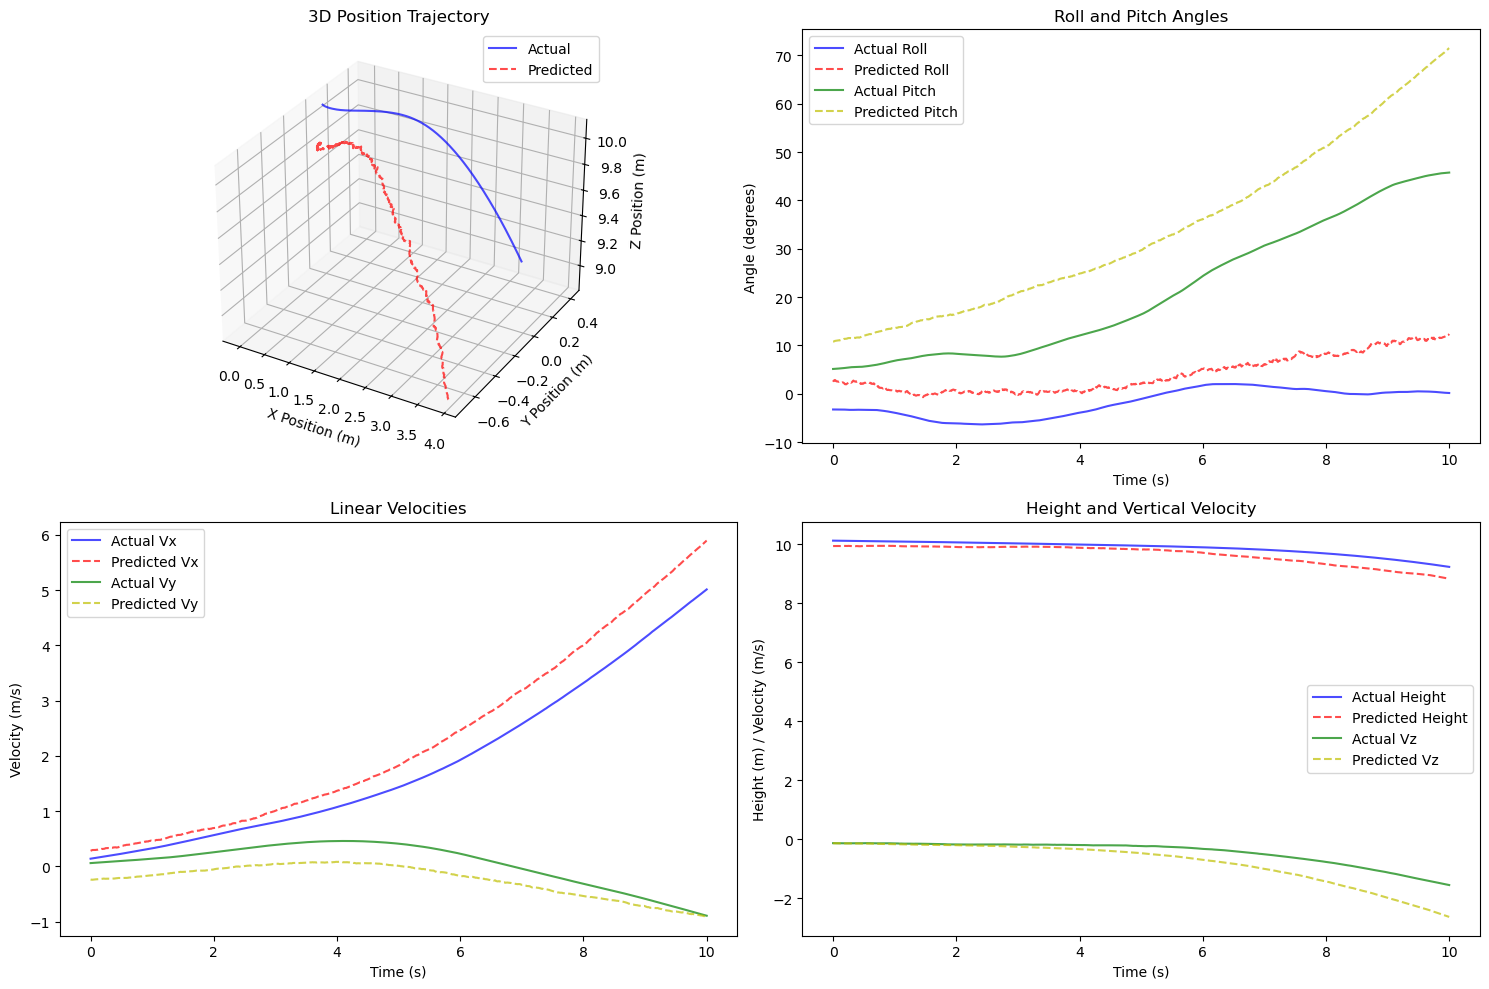

Plots saved in quadcopter_plots directory as:
- quadcopter_analysis-2.1(1).png (300 DPI)
- quadcopter_analysis-2.1(1).pdf
- quadcopter_analysis-2.1(1).svg


In [39]:
# Get a test trajectory from dataset
test_data = dataset[2].to(device)

# Get predictions
with torch.no_grad():
    predicted = model(test_data).cpu().numpy()
    actual = test_data.x.cpu().numpy()
# Create the visualization
fig = plt.figure(figsize=(15, 10))

# 3D trajectory plot
ax1 = fig.add_subplot(221, projection='3d')
ax1.plot(actual[:, 0], actual[:, 1], actual[:, 2], 
         'b-', label='Actual', alpha=0.7)
ax1.plot(predicted[:, 0], predicted[:, 1], predicted[:, 2], 
         'r--', label='Predicted', alpha=0.7)
ax1.set_xlabel('X Position (m)')
ax1.set_ylabel('Y Position (m)')
ax1.set_zlabel('Z Position (m)')
ax1.set_title('3D Position Trajectory')
ax1.legend()

# Euler angles plot
ax2 = fig.add_subplot(222)
time = np.arange(len(actual)) * 0.01  # Assuming dt=0.01
ax2.plot(time, np.rad2deg(actual[:, 6]), 'b-', label='Actual Roll', alpha=0.7)
ax2.plot(time, np.rad2deg(predicted[:, 6]), 'r--', label='Predicted Roll', alpha=0.7)
ax2.plot(time, np.rad2deg(actual[:, 7]), 'g-', label='Actual Pitch', alpha=0.7)
ax2.plot(time, np.rad2deg(predicted[:, 7]), 'y--', label='Predicted Pitch', alpha=0.7)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Angle (degrees)')
ax2.set_title('Roll and Pitch Angles')
ax2.legend()

# Linear velocities plot
ax3 = fig.add_subplot(223)
ax3.plot(time, actual[:, 3], 'b-', label='Actual Vx', alpha=0.7)
ax3.plot(time, predicted[:, 3], 'r--', label='Predicted Vx', alpha=0.7)
ax3.plot(time, actual[:, 4], 'g-', label='Actual Vy', alpha=0.7)
ax3.plot(time, predicted[:, 4], 'y--', label='Predicted Vy', alpha=0.7)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Velocity (m/s)')
ax3.set_title('Linear Velocities')
ax3.legend()

# Height and vertical velocity plot
ax4 = fig.add_subplot(224)
ax4.plot(time, actual[:, 2], 'b-', label='Actual Height', alpha=0.7)
ax4.plot(time, predicted[:, 2], 'r--', label='Predicted Height', alpha=0.7)
ax4.plot(time, actual[:, 5], 'g-', label='Actual Vz', alpha=0.7)
ax4.plot(time, predicted[:, 5], 'y--', label='Predicted Vz', alpha=0.7)
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Height (m) / Velocity (m/s)')
ax4.set_title('Height and Vertical Velocity')
ax4.legend()

plt.tight_layout()

save_folder = "quadcopter_plots"
os.makedirs(save_folder, exist_ok=True)

plt.savefig(os.path.join(save_folder, 'quadcopter_analysis.png'), 
            dpi=300, bbox_inches='tight')

plt.savefig(os.path.join(save_folder, 'quadcopter_analysis.pdf'), 
            bbox_inches='tight')

plt.savefig(os.path.join(save_folder, 'quadcopter_analysis.svg'), 
            bbox_inches='tight')

plt.show()

print(f"Plots saved in {save_folder} directory as:")
print("- quadcopter_analysis-2.1(1).png (300 DPI)")
print("- quadcopter_analysis-2.1(1).pdf")
print("- quadcopter_analysis-2.1(1).svg")